In [282]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

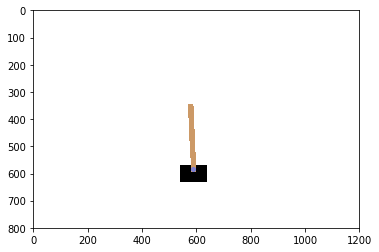

In [323]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
n_observation = env.observation_space.shape[0]
plt.imshow(env.render("rgb_array"))

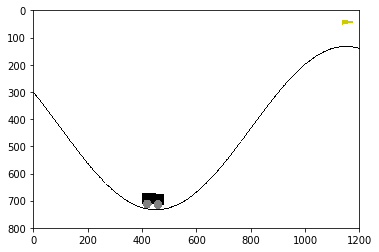

In [55]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("MountainCar-v0").env

env.reset()
n_actions = env.action_space.n
n_observation = env.observation_space.shape[0]
plt.imshow(env.render("rgb_array"))

In [324]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [325]:
class MLP(nn.Module):
    def __init__(self, D_in, D_out):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, D_out)
        )
        self.logprob = nn.Softmax(dim=1)
        
        # Episode policy and reward history 
        self.policy_history = Variable(torch.Tensor()) 
        self.reward_episode = []
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        
    def forward(self, x):
        y = self.layers(x)
        y = self.logprob(y)
        return y

In [326]:
agent = MLP(n_observation, n_actions)
optimizer = optim.Adam(agent.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [327]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [328]:
def generate_session(t_max=1000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        # predict array of action probabilities
        probs = agent(Variable(torch.FloatTensor([s]), volatile=True))[0].detach().numpy()

        a = np.random.choice(n_actions, p=probs)
        
        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [329]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """

    
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = [s for i, s in enumerate(states_batch) if rewards_batch[i] >= reward_threshold]
    elite_actions = [a for i, a in enumerate(actions_batch) if rewards_batch[i] >= reward_threshold]

#     elite_states = states_batch[rewards_batch>reward_threshold]
#     elite_actions = actions_batch[rewards_batch>reward_threshold]
    
    return elite_states, elite_actions

mean reward = 170.060, threshold=173.400


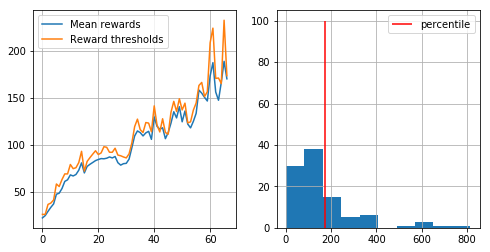

KeyboardInterrupt: 

In [330]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [ generate_session()  for _ in range(n_sessions) ]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)
    elite_states, elite_actions  = map(np.concatenate, [elite_states, elite_actions])

    pred = agent.forward(Variable(torch.FloatTensor(elite_states), volatile=True))
    loss = criterion(pred, torch.tensor(elite_actions))
    
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

### Results

In [321]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


/Users/tdtce/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/tdtce/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/tdtce/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/tdtce/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/tdtce/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWar

In [322]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices